In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
import sys 
from os import path as pt
import numpy as np
import matplotlib.pyplot as plt
import ot

L:
[[1 0 0]
 [1 2 0]
 [1 2 1]]
A = LL^T:
[[1 1 1]
 [1 5 5]
 [1 5 6]]
M:
[[1 0 0]
 [2 1 0]
 [2 1 2]]
B = MM^T:
[[1 2 2]
 [2 5 5]
 [2 5 9]]


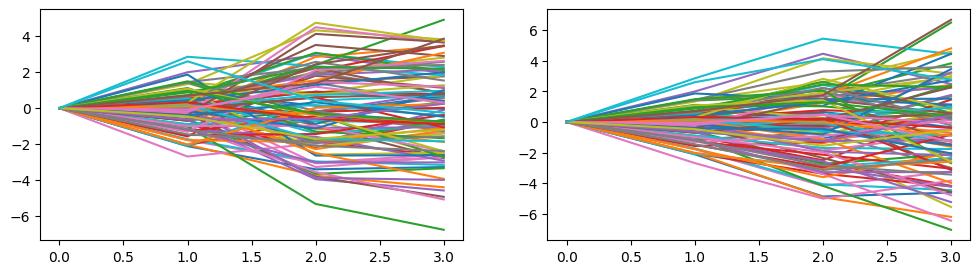

In [2]:
# Initialize samples
T = 4 # The first time is always 0, so the non trivial timestep is T-1 here
n_sample = 20000
normalize = False

L0 = np.array([[1, 0, 0], [1, 2, 0], [1, 2, 1]])
A0 = L0 @ L0.T  # A = LL^T
L = L0 / np.sqrt(np.trace(A0)) if normalize else L0
A = L @ L.T
# np.linalg.cholesky(A) -  L

M0 = np.array([[1, 0, 0], [2, 1, 0], [2, 1, 2]])
B0 = M0 @ M0.T  # A = LL^T
M = M0 / np.sqrt(np.trace(B0)) if normalize else M0
B = M @ M.T

# np.linalg.cholesky(B) -  M

print('L:')
print(L)
print('A = LL^T:')
print(A)

print('M:')
print(M)
print('B = MM^T:')
print(B)

noise1 = np.random.normal(size=[T-1, n_sample])  # (dim, n_sample)
noise2 = np.random.normal(size=[T-1, n_sample])  # (dim, n_sample)
X = L @ noise1  # (dim, n_sample)
Y = M @ noise1  # (dim, n_sample)
X = np.concatenate([np.zeros_like(X[:1]), X], axis=0)
Y = np.concatenate([np.zeros_like(Y[:1]), Y], axis=0)

fig, ax = plt.subplots(1, 2, figsize=[12, 3])
ax[0].plot(X[:,:100])
ax[1].plot(Y[:,:100])
plt.show()

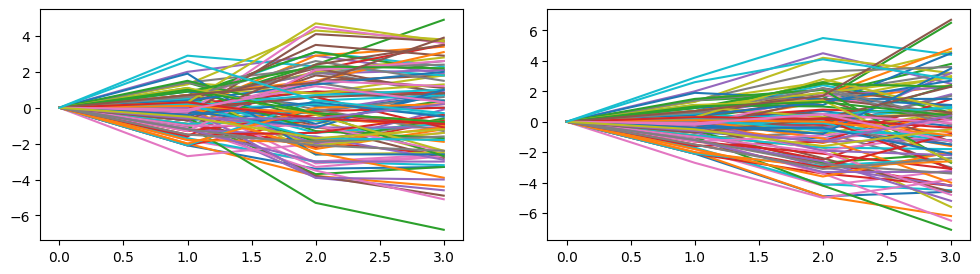

In [3]:
# Grid projection of k-mean projection
def adapted_empirical_measure(samples, delta_n):
    grid_func = lambda x: np.floor(x / delta_n + 0.5) * delta_n
    adapted_samples = grid_func(samples)
    return adapted_samples

adaptedX = adapted_empirical_measure(X, delta_n = 0.1)
adaptedY = adapted_empirical_measure(Y, delta_n = 0.1)

fig, ax = plt.subplots(1,2, figsize=[12,3])
ax[0].plot(adaptedX[:,:100])
ax[1].plot(adaptedY[:,:100])
plt.show()

In [4]:
# Quantization 
# Here I use the biggest one which works for both X and Y samples grid for simplicity.
q2v_list = np.unique(np.concatenate([adaptedX,adaptedY],axis = 0)) 
v2q_dict = {k: v for v, k in enumerate(q2v_list)}
# q2v_list, v2q_dict
len(q2v_list)

216

In [5]:
from collections import defaultdict

def path2cm(adaptedpath):
    r'''
    Path to Conditional Measure
    '''
    mu_x = [defaultdict(dict) for t in range(T-1)]
    for path in adaptedpath.T:
        for t in range(T-1):
            pre_path = v2q_dict[path[t]]
            next_val = v2q_dict[path[t+1]]
            if pre_path not in mu_x[t] or next_val not in mu_x[t][pre_path]:
                mu_x[t][pre_path][next_val] = 1
            else:
                mu_x[t][pre_path][next_val] += 1
    return mu_x
mu_x = path2cm(adaptedX)
nu_y = path2cm(adaptedY)

# %lprun -f path2cm path2cm(adaptedX)

In [13]:
def nested_markovian_old(mu_x, nu_y, square_cost_matrix):
    T = len(mu_x)+1
    V = [{} for t in range(T-1)]
    for t in range(T-2,-1,-1):
        print(t)
        for k1,v1 in mu_x[t].items():
            for k2,v2 in nu_y[t].items():
                w1 = list(v1.values())
                w1 = np.array(w1)/sum(w1)

                w2 = list(v2.values())
                w2 = np.array(w2)/sum(w2)

                q1s = list(v1.keys())
                q2s = list(v2.keys())

                cost = square_cost_matrix[np.ix_(q1s,q2s)]
                if t < T-2:
                    for i, q1 in enumerate(q1s):
                        for j, q2 in enumerate(q2s):
                            q_pair = (q1,q2)
                            cost[i,j] += V[t+1][q_pair]    # THIS PART WE CAN OPTIMIZE

                V[t][(k1,k2)] = ot.emd2(w1, w2, cost)

    AW_2square = list(V[0].values())[0]
    return AW_2square

In [14]:
def nested_markovian(mu_x, nu_y, square_cost_matrix):
    T = len(mu_x)+1
    V = [np.zeros([len(q2v_list),len(q2v_list)]) for t in range(T-1)]
    # V = [{} for t in range(T-1)]
    for t in range(T-2,-1,-1):
        print(t)
        for k1,v1 in mu_x[t].items():
            for k2,v2 in nu_y[t].items():
                w1 = list(v1.values())
                w1 = np.array(w1)/sum(w1)

                w2 = list(v2.values())
                w2 = np.array(w2)/sum(w2)

                q1s = list(v1.keys())
                q2s = list(v2.keys())

                cost = square_cost_matrix[np.ix_(q1s,q2s)]
                if t < T-2:
                    for i, q1 in enumerate(q1s):
                        for j, q2 in enumerate(q2s):
                            q_pair = (q1,q2)
                            # cost[i,j] += V[t+1][q_pair]    # THIS PART WE CAN OPTIMIZE
                            cost[i,j] += V[t+1][q1,q2]

                # V[t][(k1,k2)] = ot.emd2(w1, w2, cost)
                V[t][k1,k2] = ot.emd2(w1, w2, cost)

    AW_2square = V[0][k1,k2]
    return AW_2square

In [15]:
square_cost_matrix = (q2v_list[None,:] - q2v_list[None,:].T)**2
AW_2square = nested_markovian(mu_x, nu_y, square_cost_matrix)
AW_2square_old = nested_markovian_old(mu_x, nu_y, square_cost_matrix)

2
1
0
2
1
0


In [11]:
square_cost_matrix = (q2v_list[None,:] - q2v_list[None,:].T)**2
# AW_2square = nested_markovian(mu_x, nu_y, square_cost_matrix)
%lprun -f nested_markovian AW_2square = nested_markovian(mu_x, nu_y, square_cost_matrix)

2
1
0


Timer unit: 1e-09 s

Total time: 13.386 s
File: /var/folders/gq/bts52kyn0v72cpz5c5489984006lvv/T/ipykernel_63955/3092318420.py
Function: nested_markovian at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nested_markovian(mu_x, nu_y, square_cost_matrix):
     2         1       1000.0   1000.0      0.0      T = len(mu_x)+1
     3         1     125000.0 125000.0      0.0      V = [np.zeros([len(q2v_list),len(q2v_list)]) for t in range(T-1)]
     4                                               # V = [{} for t in range(T-1)]
     5         4       2000.0    500.0      0.0      for t in range(T-2,-1,-1):
     6         3     243000.0  81000.0      0.0          print(t)
     7       235     107000.0    455.3      0.0          for k1,v1 in mu_x[t].items():
     8     30494    6030000.0    197.7      0.0              for k2,v2 in nu_y[t].items():
     9     30262   15522000.0    512.9      0.1                  w1 = lis

In [12]:
def adapted_wasserstein_squared(a, A, b, B):
    # Cholesky decompositions: A = L L^T, B = M M^T
    L = np.linalg.cholesky(A)
    M = np.linalg.cholesky(B)
    # Mean squared difference
    mean_diff = np.sum((a - b) ** 2)
    # Trace terms
    trace_sum = np.trace(A) + np.trace(B)
    # L1 norm of diagonal elements of L^T M
    l1_diag = np.sum(np.abs(np.diag(L.T @ M)))
    # Final adapted Wasserstein squared distance
    return mean_diff + trace_sum - 2 * l1_diag

a, b  = np.zeros([3]), np.zeros([3])
dist_bench = adapted_wasserstein_squared(a,A,b,B)
print('Theoretical AW_2^2: ', dist_bench)
print('Numerical AW_2^2: ', AW_2square)

Theoretical AW_2^2:  5.0
Numerical AW_2^2:  5.15474653119413


In [ ]:
5.023186843354662